# Introduction

The intention of the short-term drought forecaster (STDF) is to predict weather and soil moisture for the upcoming year at a fine temporal and spatial scale.

The Climate Prediction Center (CPC) of the National Weather Service (NWS) provides “long-lead” outlooks for temperature and precipitation for 102 regions in the lower 48 of the United States.

![image](images/Screen Shot 2020-05-03 at 6.40.01 PM.png)

These outlooks consist of the probability of whether a region will be hotter or cooler (temperature) and wetter or drier (precipitation) than their 30-year climatological normal (1980-2010) for 1 1-month and 13 3-month outlooks. These outlooks are updated on the 15th of each month and the 1-month outlook is for the nearest upcoming month while the 3-month outlooks consist of 13 total forecasts for the next year. The 3-month outlooks overlap one another, and each individual month is included in up to 3 outlooks. For example, on May 15th, the closest 1-month outlook would be for June, and the nearest 3-month outlook would be for June-July-August. There are subsequent outlooks for July-August-September, August-September-October, and so on for the next 13 month period.

![image](https://www.cpc.ncep.noaa.gov/products/predictions/multi_season/13_seasonal_outlooks/color/page2.gif)

# National Weather Service Forecasts

The NWS uses "probability of exceedance" curves to give the forecast probability that a temperature or precipitation quantity will be exceeded at the location in question, for the forecast period. 

[temperature probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=t)

[precipitation probability of exceedence curve](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/poe_graph_index.php?lead=1&climdiv=97&var=p)

In addition to the probability of exceedance, a ‘point forecast’ is given for the mean forecasted anomaly and the standard deviation (SD) of that anomaly, as well as percentile (%ile) that this mean will exceed the climatological mean (top left corners of the above figures). These probability of exceedance curves are generated for each outlook and region and are the basis for the information we see in the maps above. NWS meteorologists makes these forecasts using a series of models and tools that evaluate historical patterns as well as current global atmospheric and oceanic patterns. Full discussion [here](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/tools.php).

Our intent with the short-term forecaster is to translate the information from the NWS CPC into predictions that are fine-tuned for specific locations, instead of the broad outlooks provided for 102 regions. In addition, we translate these predictions to a finer temporal scale, so we are able to utilize them as the climate driver in in a daily driven, water-balance model, SOILWAT2. SOILWAT2 is a site-specific model, that takes inputs about daily weather, vegetation, and soils (multi-layer), and mechanistically predicts daily soil moisture, a metric used for evaluating likely success of plant germination and survival.

# Downscaling Methods

First, for each set of coordinates, the appropriate region is determined from the map above and the affiliated temperature and precipitation NWS long-lead forecast data are grabbed. Temperature and precipitation data are stored online in tabular form, [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllftd.dat) and [here](https://www.cpc.ncep.noaa.gov/pacdir/NFORdir/HUGEdir2/cpcllfpd.dat).


In [7]:
# Setup
# load all packages and read in most all data for this notebook
library(raster)
library(data.table)
library(ggplot2)
library(lubridate)

wdata <- fread('wdata.csv') # historical, site-specific weather data
generatedAnomData <- readRDS('ExampleData/generatedAnomData') # generated anomalies at the lead-level
MonthlyAnoms <- fread('ExampleData/MonthlyAnoms.csv') # anomalies averaged to the monthly level

HistDataNormMean <- fread('ExampleData/HistDataNormMean.csv')
AnomRunStats <- fread('ExampleData/AnomRunStats.csv')

source('functions/weatherFunctions.R')
currMonth <- month(Sys.Date())

Nleads <- 12


In [9]:
# Set coordinates
lat <- 35.1266
lng <- -111.5854

# Determine Region from coordinates and shapefile ------------------------------------------
CD102 <- shapefile(x = 'CD102/CD102.shp')
points <- data.frame(x = lng, y = lat)

coordinates(points) <- ~ x + y 
proj4string(points) <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")

CDRegion <- as.numeric(over(points, CD102)$ID4)

# Read in and subset anomaly data -----------------------------------------------------------
TempAnomsWhole <- fread('CurrentAnomalyTempData.csv')
TempAnoms <- subset(TempAnomsWhole, CD == CDRegion)
TempAnoms <- TempAnoms[1:Nleads, ]

PPTAnomsWhole <- fread('CurrentAnomalyPPTData.csv')
PPTAnoms <- subset(PPTAnomsWhole, CD == CDRegion)
PPTAnoms <- PPTAnoms[1:Nleads, ]

# Convert values and calculate NWS anomalies or correction factors \-------------------------------------------
  
# Temp
TempAnoms$ClimatologicalMEAN_Temp_C <- (TempAnoms$ClimatologicalMEAN - 32) * (5/9)
TempAnoms$ForecastedMEAN_Temp_C <- (TempAnoms$ForecastedMEAN - 32) * (5/9)
  
TempAnoms$ForecastedSD_Temp_C <- (TempAnoms$ForecastedSD) * (5/9)
TempAnoms$Anom_F <- TempAnoms$ForecastedMEAN - TempAnoms$ClimatologicalMEAN
TempAnoms$Anom_C <- TempAnoms$Anom_F * (5/9)
  
# PPT - keep in transformed units for calcs downstream
## PPT - SDs are given in transformed units. Means are in inches. 
backT <- 1/PPTAnoms$PO

# convert
PPTAnoms$ClimatatologicalMEAN_PPT_PO <- PPTAnoms$ClimatologicalMEAN ^ PPTAnoms$PO
PPTAnoms$ClimatatologicalMEAN_PPT_cm <- PPTAnoms$ClimatologicalMEAN * 2.54
  
PPTAnoms$ForecastedMEAN_PPT_PO <- PPTAnoms$ForecastedMEAN ^ PPTAnoms$PO
PPTAnoms$ForecastedMEAN_PPT_cm <- PPTAnoms$ForecastedMEAN * 2.54
  
PPTAnoms$ForecastedSD_PPT_in <- as.numeric(PPTAnoms$ForecastedSD) ^ backT
PPTAnoms$ForecastedSD_PPT_cm <- PPTAnoms$ForecastedSD_PPT_in * 2.54
  
# calc - anomaly NEEDS to be calcualted in transformed units
PPTAnoms$Anom_PO <- PPTAnoms$ForecastedMEAN_PPT_PO - PPTAnoms$ClimatatologicalMEAN_PPT_PO
PPTAnoms$Anom_cm <- PPTAnoms$ForecastedMEAN_PPT_cm - PPTAnoms$ClimatatologicalMEAN_PPT_cm
PPTAnoms$Anom_CF <- PPTAnoms$ForecastedMEAN / PPTAnoms$ClimatologicalMEAN

print('NWS Temperature Data')
head(TempAnoms)
print('NWS Precipitation Data')
head(PPTAnoms)

[1] "NWS Temperature Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,ClimatologicalMEAN_Temp_C,ForecastedMEAN_Temp_C,ForecastedSD_Temp_C,Anom_F,Anom_C
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,70.97,69.98,1.2039,1.35,21.100000,21.650000,0.6688333,0.99,0.5500000
2020,5,2,97,69.64,68.80,1.0297,1.14,20.444444,20.911111,0.5720556,0.84,0.4666667
2020,5,3,97,63.00,62.12,1.0835,1.19,16.733333,17.222222,0.6019444,0.88,0.4888889
2020,5,4,97,53.41,52.51,1.2727,1.40,11.394444,11.894444,0.7070556,0.90,0.5000000
2020,5,5,97,43.42,42.38,1.3283,1.44,5.766667,6.344444,0.7379444,1.04,0.5777778
2020,5,6,97,36.88,35.83,1.6065,1.64,2.127778,2.711111,0.8925000,1.05,0.5833333


[1] "NWS Precipitation Data"


YEAR,MN,LEAD,CD,ForecastedMEAN,ClimatologicalMEAN,ForecastedSD,ClimatologicalSD,PO,ClimatatologicalMEAN_PPT_PO,ClimatatologicalMEAN_PPT_cm,ForecastedMEAN_PPT_PO,ForecastedMEAN_PPT_cm,ForecastedSD_PPT_in,ForecastedSD_PPT_cm,Anom_PO,Anom_cm,Anom_CF
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,5,1,97,4.72,4.72,0.3000,0.30,0.49,2.139102,11.9888,2.139102,11.9888,0.085684155,0.21763775,0.000000000,0.0000,1.000000
2020,5,2,97,5.89,5.89,0.4800,0.48,0.61,2.949649,14.9606,2.949649,14.9606,0.300223478,0.76256763,0.000000000,0.0000,1.000000
2020,5,3,97,5.22,5.20,0.5051,0.51,0.68,3.068190,13.2080,3.076210,13.2588,0.366260638,0.93030202,0.008019568,0.0508,1.003846
2020,5,4,97,3.72,3.66,0.2998,0.30,0.40,1.680322,9.2964,1.691286,9.4488,0.049212913,0.12500080,0.010964782,0.1524,1.016393
2020,5,5,97,3.74,3.33,0.2481,0.25,0.28,1.400504,8.4582,1.446785,9.4996,0.006885773,0.01748986,0.046281068,1.0414,1.123123
2020,5,6,97,3.30,3.30,0.2400,0.24,0.27,1.380380,8.3820,1.380380,8.3820,0.005063911,0.01286233,0.000000000,0.0000,1.000000


Note: Long-lead forecasts are predictions for rolling 3-month long windows. Temperature values (C) are means across 3-month windows and precipitation values (inches) are sums. For example, a Lead of 1, refers to the months of June-July-August, Lead 2 refers to July-August-September, and so on and so forth. In order to correctly predict monthly values from the lead data we need to look at what leads are affiliated with each month. To switch between leads and months, we create a monthLeads table.

In [10]:
print("Months & Leads Table")

monthLeads <- makeMonthLeadRelationshipTable(TempAnoms)
monthLeads


[1] "Months & Leads Table"


LEAD,Month,lead1,lead2,lead3
<int>,<dbl>,<int>,<dbl>,<dbl>
1,6,1,NA,NA
2,7,2,1,NA
3,8,3,2,1
4,9,4,3,2
5,10,5,4,3
6,11,6,5,4
7,12,7,6,5
8,1,8,7,6
9,2,9,8,7


Next, because the future forecast for each lead are probability curves of potential values we want to create a numerical distribution of potential futures using the NWS data. To accomplish this, we use multivariate sampling that considers the covariance between historical temperature and precipitation anomalies, as well as the NWS forecast for the mean and standard deviation in the coming months. 

For these broad forecasts to reflect site-specific climatology we apply these regional anomalies to site-specific historical data. Specifically, for a point location (lat, long) historical weather data (1980 – current) is downloaded from [gridMet](http://www.climatologylab.org/gridmet.html), a daily, high-spatial resolution surface meteorological dataset, using the geoknife package.

To create our sample, we first calculate monthly mean temperature and the monthly sum of precipitation for each month in a 30 year climatic normal period (1981 - 2020). Then, using the roll apply function, we mean and sum these monthly values to their affiliated NWS lead. The difference between the NWS lead and historical lead data is calculated, to create an array of meteorological anomalies. The covariance between the lead anomaly values is then calculated in order to apply multivariate sampling. The multivariate sample considerrs each lead period and looks at covariance, the forecasted standard deviation, and the forecasted anomaly. All precipitation calculations are performed in transformed units.

We would expect these generated anomaly values to have the same mean, standard deviation, and covariance structure as our dataset. Below we are looking at a sample set of anomalies (n = 100)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.5906  0.2863  1.1519  2.7531  2.2351 47.4350 

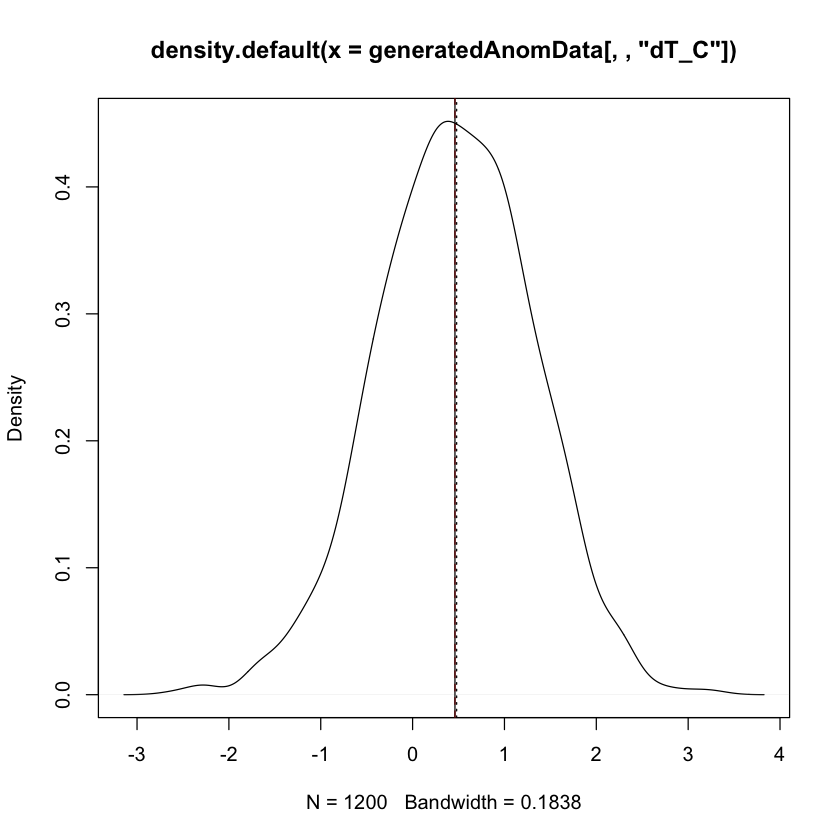

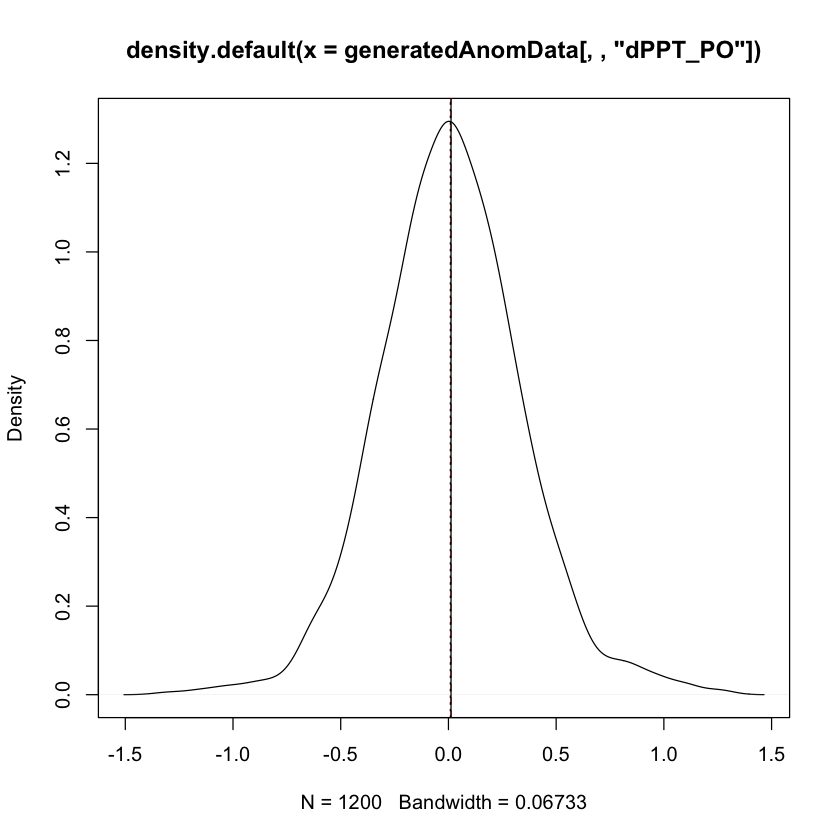

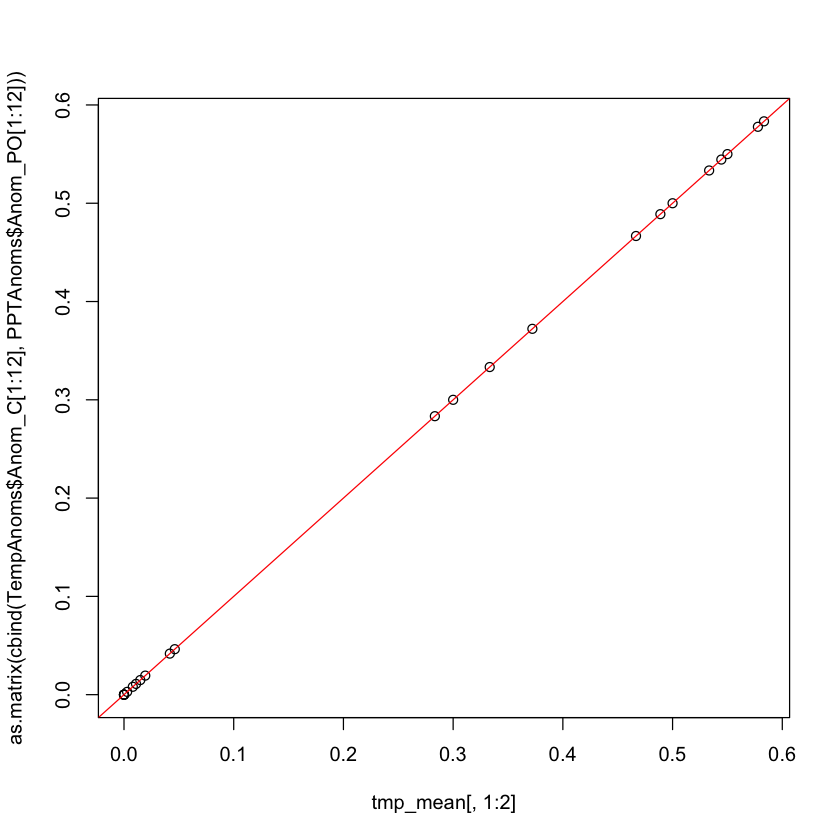

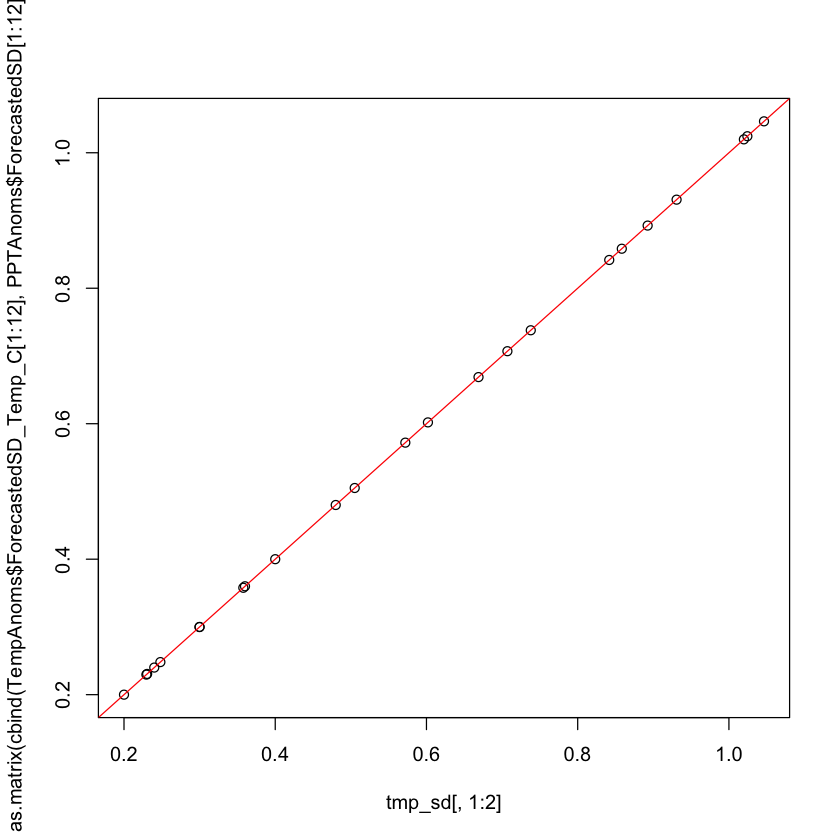

In [11]:
# function to create anomaly data - for now we will look at saved data
  #generatedAnomData <- generateAnomalyData(monthlyWdata, TempAnoms, PPTAnoms, 
  #                                         leads = seq_len(Nleads), Nleads = Nleads, 
  #                                         n = n)

summary(generatedAnomData)

# Check that means have no bias compared to forecasted NWS means
plot(density(generatedAnomData[, , "dT_C"]))
abline(v = mean(TempAnoms$Anom_C), col = "red", lty = 2)
abline(v = mean(generatedAnomData[, , "dT_C"]))
abline(v = median(generatedAnomData[, , "dT_C"]), lty = 3)

plot(density(generatedAnomData[, , "dPPT_PO"]))
abline(v = mean(PPTAnoms$Anom_PO), col = "red", lty = 2)
abline(v = mean(generatedAnomData[, , "dPPT_PO"]))
abline(v = median(generatedAnomData[, , "dPPT_PO"]), lty = 3)


# Check that means have no bias compared to forecasted NWS means
tmp_mean <- apply(
  X = generatedAnomData,
  MARGIN = c(1,3),
  FUN = mean
)

plot(
  tmp_mean[,1:2],
  as.matrix(cbind(TempAnoms$Anom_C[1:12], PPTAnoms$Anom_PO[1:12]))
)
abline(0, 1, col = "red")


# Check that SDs have no bias compared to forecasted NWS SDs
tmp_sd <- apply(
  X = generatedAnomData,
  MARGIN = c(1,3),
  FUN = sd
)

plot(
  tmp_sd[,1:2],
  as.matrix(cbind(TempAnoms$ForecastedSD_Temp_C[1:12], PPTAnoms$ForecastedSD[1:12]))
)
abline(0, 1, col = "red")

# TO do - add covariances.

Next, the anomalies generated for each lead must be transformed into monthly values so we can apply the anomalies to the historical data. Using the monthLeads table we loop through each month and find the affiliated leads. Values are then averaged across leads for monthly temperature anomaly and precipiation correction factor.

Finally, these monthly anomalies are then added (temp) or multipled (ppt) to each day in the relative month across the historical series, to generate future daily data for a 30 year period.


In [12]:
# Step 3 Get monthly averages across leads --------------------------------------------------
nn <- 1
OneYearAnom <- generatedAnomData[ , nn, ]
    
yearlydat <- data.frame(matrix(nrow = 12, ncol = 3))
names(yearlydat) <- c('tempAnom', 'pptAnom_cm', 'pptAnom_CF')
yearlydat$Month <- as.numeric(row.names(yearlydat))
  
for(m in c(yearlydat$Month)){ # for each month, m, in a year, nn
    
    mLeads <- c(t(monthLeads[monthLeads$Month == m, 3:5]))

    #temp
    yearlydat[m, 1] <- mean(OneYearAnom[mLeads, 'dT_C'], na.rm = TRUE) 
      
    # ppt cm # don't use this for calculations but downstream for looking at differences in predicted data
    OneYearAnom  <- cbind(OneYearAnom, Anom_cm =  OneYearAnom[,4] - PPTAnoms$ClimatatologicalMEAN_PPT_cm[1:12])
    yearlydat[m, 2] <-  mean(OneYearAnom[mLeads, 'Anom_cm'], na.rm = TRUE)/sum(!is.na(mLeads))
      
    # ppt correction factor
    yearlydat[m, 3] <-  mean(OneYearAnom[mLeads, 'PPT_CF'], na.rm = TRUE)

}
print(yearlydat)

print('summary of weather data before anomalies')
summary(wdata)
### Find month in wdata and merge anomalies
wdata$Month <-  month(as.Date(strptime(paste(wdata$Year, wdata$DOY), format="%Y %j"), format="%m-%d-%Y"))
wdata <- merge(wdata, yearlydat)

### Temp ------------------------------------------------------------------------------------ 
wdata$Tmax_C <- wdata$Tmax_C + wdata$tempAnom
wdata$Tmin_C <- wdata$Tmin_C + wdata$tempAnom

### Precip ----------------------------------------------------------------------------
wdata$PPT_cm <- wdata$PPT_cm * wdata$pptAnom_CF

# That's it
wdata <- wdata[,c('Year', 'DOY', 'Tmax_C', 'Tmin_C', 'PPT_cm')]
print('summary of weather data after anomalies')
summary(wdata)

      tempAnom  pptAnom_cm pptAnom_CF Month
1   0.84101959  0.05287866  1.0172948     1
2   0.74563454  0.51505961  1.1827849     2
3   0.22564461  0.21186961  1.1267534     3
4  -0.22949111  0.23701736  1.0530290     4
5  -0.02476724  0.04232230  0.9711551     5
6   1.06724653 -1.12951772  0.9057856     6
7   0.85676186 -0.93485889  0.8656664     7
8   0.83946898 -0.59858882  0.8688568     8
9   0.38133399 -0.07920667  1.0273689     9
10  0.41863883  0.38370741  1.1468531    10
11  0.50204294  0.12624379  1.0307601    11
12  0.87962423  0.41292295  1.1386850    12
[1] "summary of weather data before anomalies"


     Date                Year           DOY            Tmax_C      
 Length:15341       Min.   :1979   Min.   :  1.0   Min.   :-8.912  
 Class :character   1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.202  
 Mode  :character   Median :2000   Median :183.0   Median :17.783  
                    Mean   :2000   Mean   :183.1   Mean   :17.403  
                    3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.264  
                    Max.   :2020   Max.   :366.0   Max.   :44.891  
     Tmin_C             PPT_cm       
 Min.   :-25.3087   Min.   :0.00000  
 1st Qu.: -4.5787   1st Qu.:0.00000  
 Median :  0.7622   Median :0.00000  
 Mean   :  1.3686   Mean   :0.15378  
 3rd Qu.:  7.9749   3rd Qu.:0.06728  
 Max.   : 32.2334   Max.   :9.29819  

[1] "summary of weather data after anomalies"


      Year           DOY            Tmax_C           Tmin_C       
 Min.   :1979   Min.   :  1.0   Min.   :-8.166   Min.   :-24.429  
 1st Qu.:1989   1st Qu.: 92.0   1st Qu.:10.707   1st Qu.: -4.103  
 Median :2000   Median :183.0   Median :18.027   Median :  1.008  
 Mean   :2000   Mean   :183.1   Mean   :17.944   Mean   :  1.910  
 3rd Qu.:2010   3rd Qu.:274.0   3rd Qu.:25.838   3rd Qu.:  8.614  
 Max.   :2020   Max.   :366.0   Max.   :45.958   Max.   : 33.301  
     PPT_cm       
 Min.   :0.00000  
 1st Qu.:0.00000  
 Median :0.00000  
 Mean   :0.15842  
 3rd Qu.:0.06579  
 Max.   :9.45900  

Next, three-year long SOILWAT2 simulations are run using this data. First year is observed data for spin up , second year is part observed and the future, third year is the rest of the future and then dummy data after today's date + 12 months. The anomalies are applied to each year in the historical record for each future (i.e. 30 years). EAch year is run individually so therre is proper spin up and not confound the accumulation of certain conditions and represent the range of possible conditions at the site. This entire process is repeated 30 times, resulting in 900 years.

# Downscaling Results




## Temperature

### Leads -  Generated lead anomaly data vs. NWS lead forecasts

[1] "Density plots of predicted LEAD Anomalies"


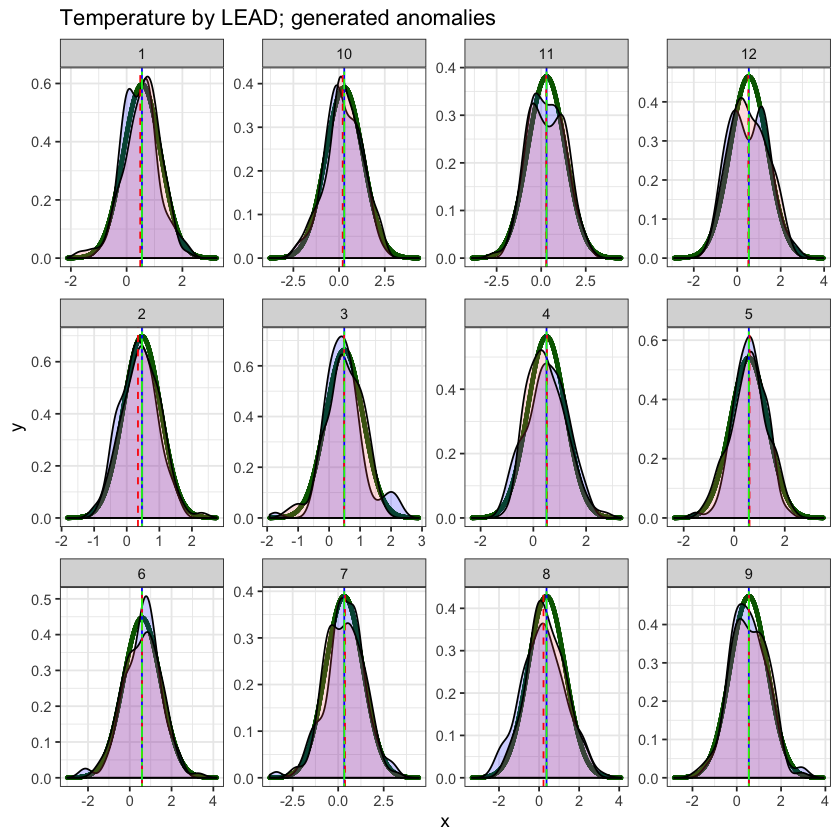

In [19]:
print('Density plots of predicted LEAD Anomalies')
# the anomaly from NWS is the thick blue line. Sample distribution of NWS data is blue
# the mean of the our generated anomlies is the dashed red line. Distribution in pink
# theoretical distribution in green
# 100 Future realizations as density plots

#------ Check generated anamalies against NWS anomalies
# NWS random sample
tempNWSDensity <- TempAnoms[,.(vals = rnorm(100, mean = Anom_C, sd = ForecastedSD_Temp_C)),
                            .(LEAD)]
tempNWSDensityMean <- tempNWSDensity[,.(Anom_mean = mean(vals)), .(LEAD)]

# Theoretical sample
tempTheoreticalDensity <- data.frame()

for(i in 1:12){
  z <- subset(TempAnoms, LEAD == i)
  x <-  seq(z$Anom_C - (z$ForecastedSD_Temp_C * 4), 
            z$Anom_C + (z$ForecastedSD_Temp_C * 4), length = 3000) 
  y <-  dnorm(x, mean = z$Anom_C, sd = z$ForecastedSD_Temp_C)
  
  tempTheoreticalDensity <- rbind(tempTheoreticalDensity, data.frame(x = x, y = y, LEAD = i))
}
tempTheoreticalDensityMean <-setDT(tempTheoreticalDensity)[,.(Anom_mean = mean(x)),.(LEAD)]

# generated anomalies
tempGenAnoms <- data.table(generatedAnomData[, , "dT_C"])
tempGenAnoms$LEAD <- factor(tempGenAnoms$LEAD, levels = c(1:12))
tempGenAnoms$LEAD <- row.names(tempGenAnoms)
tempGenAnoms <- melt(tempGenAnoms, id.vars = 'LEAD')
tempGenAnomsMean <- tempGenAnoms[,.(dT_mean = mean(value)),.(LEAD)]

ggplot() +
  
  geom_point(data = tempTheoreticalDensity, aes(x = x, y = y), color = 'darkgreen',  size = .6) +
  geom_density(data = tempNWSDensity, aes(x = vals), alpha=.2, fill="blue") +
  geom_density(data = tempGenAnoms, aes(x = value), alpha=.2, fill="#FF6666") +
  
  facet_wrap(~LEAD, scales = 'free') +
  labs(title = 'Temperature by LEAD; generated anomalies') +
  
  geom_vline(data = tempGenAnomsMean, aes(xintercept = dT_mean), color = 'blue')+
  geom_vline(data = tempNWSDensityMean, aes(xintercept = Anom_mean), color = 'red', lty = 'dashed') +
  geom_vline(data = tempTheoreticalDensityMean, aes(xintercept = Anom_mean), color = 'green', lty = 'twodash') +
  theme_bw()


### Monthly - generated monthly anom data vs. NWS data (NWS lead data averaged to correct month)

[1] "Density and box plots of monthly anomalies used in SOILWAT2 vs NWS"


Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


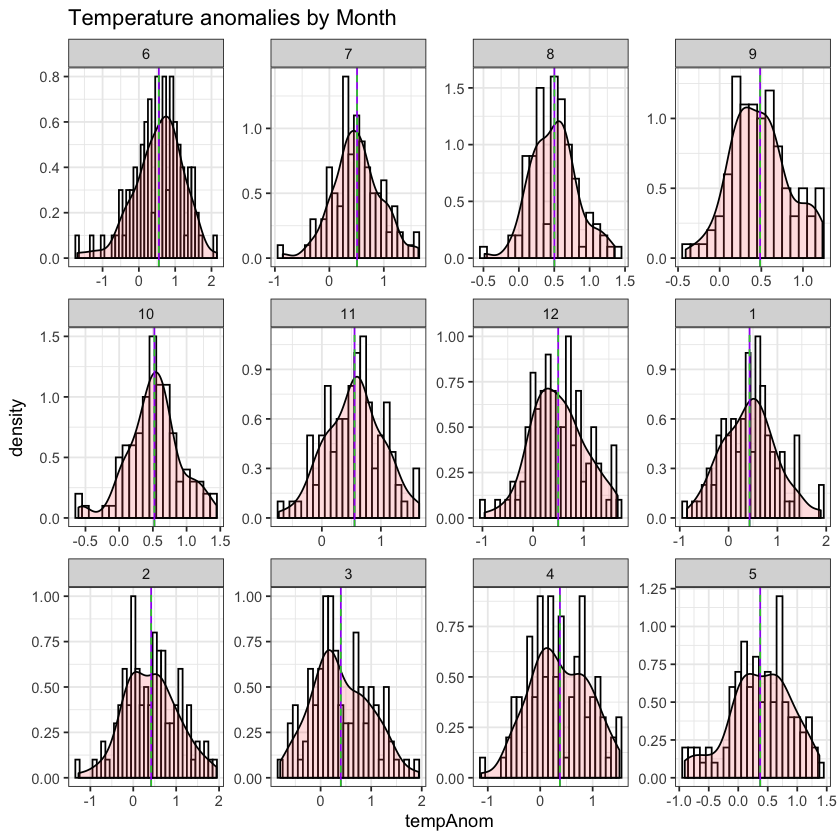

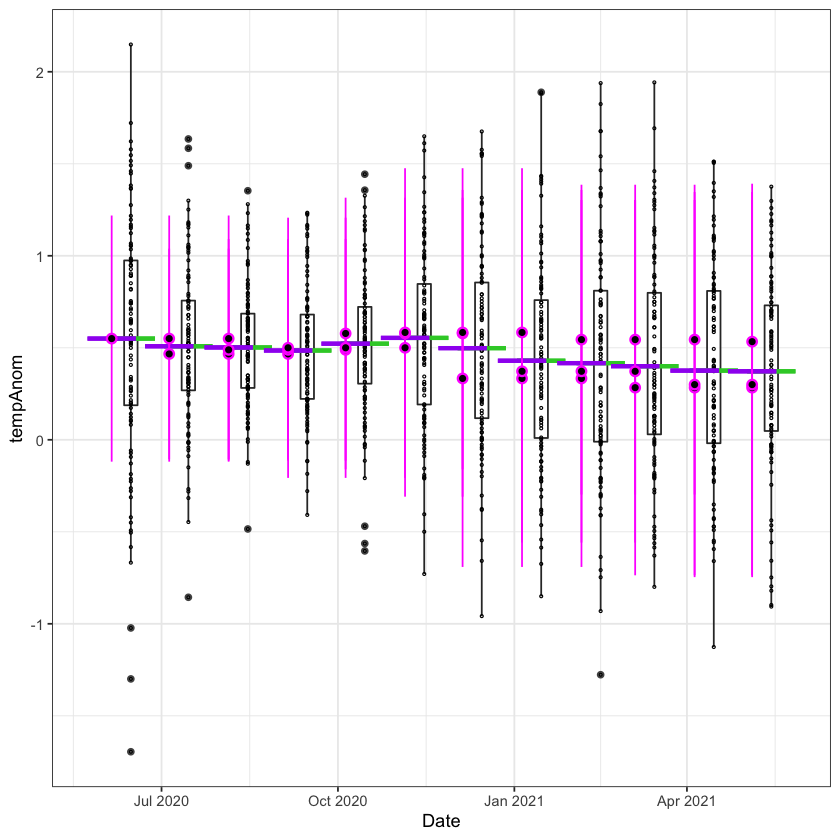

In [24]:
source('figureCode/testFigs/FigureDataPrep.R')
# Plots comparing the distribution of generated anomaly data at the Monthly level
# to NWS values for the same monthly periods

print('Density and box plots of monthly anomalies used in SOILWAT2 vs NWS')

#source('figureCode/presentationFigs/FigureDataPrep.R')
MonthlyAnoms2 <- MonthlyAnoms # monthly anamoly data entered into SW
MonthlyAnoms2$Month <- factor(MonthlyAnoms2$Month, levels = c(6:12, 1:5))
generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(tempAnom)), .(Month)]

# ----- 100 sets of monthly anomalies vs. affiliated NWS data
# temperature
NWSMeans <- setDT(NWSAnomsAll1)[,.(meanAnom = mean(Anom_C)), .(m)]
names(NWSMeans)[1] <- 'Month'
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

ggplot(MonthlyAnoms2, aes(tempAnom)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white", binwidth =.1)+
  geom_density(alpha=.2, fill="#FF6666") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Temperature anomalies by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanAnom), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw()

ggplot() + 
  geom_boxplot(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, tempAnom, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanAnom, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll1, aes(Date, Anom_C,
                                           ymin = Anom_C - ForecastedSD_Temp_C,
                                           ymax = Anom_C + ForecastedSD_Temp_C), shape = 21, fill = 'black', color = 'magenta') +
   theme_bw()
  




In [ ]:
### Tempererature time series - 18 month period - absolutes and differrences

Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”


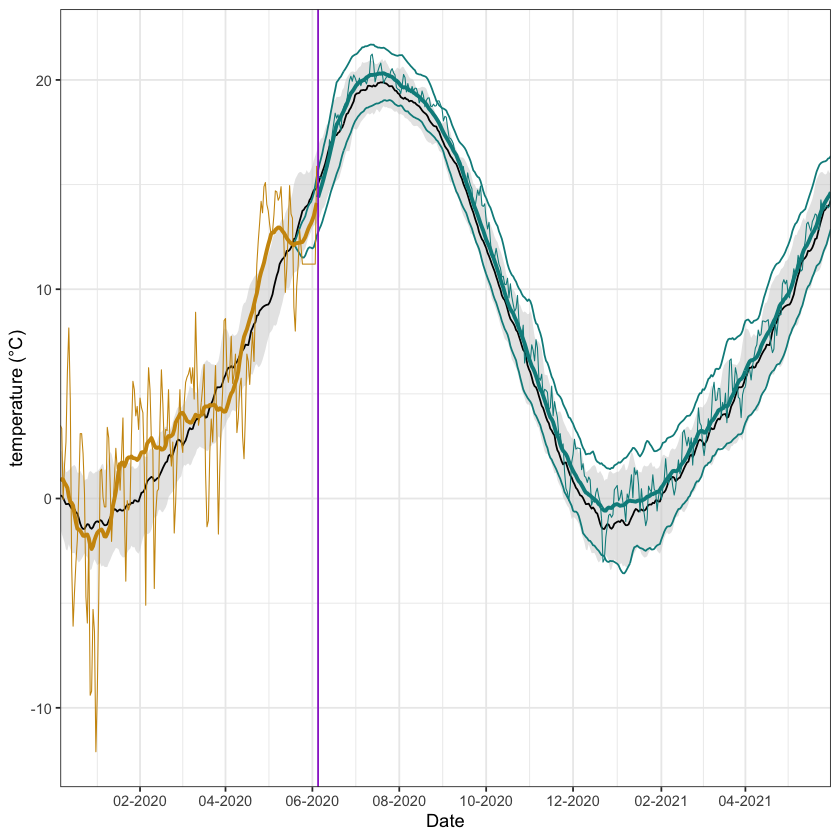

Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 181 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning messag

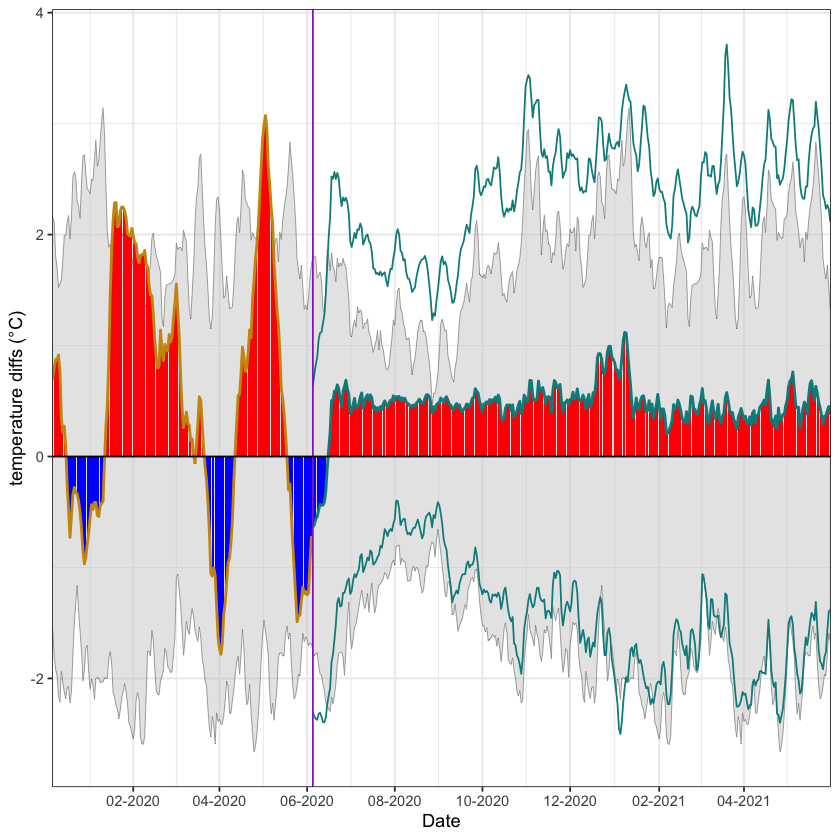

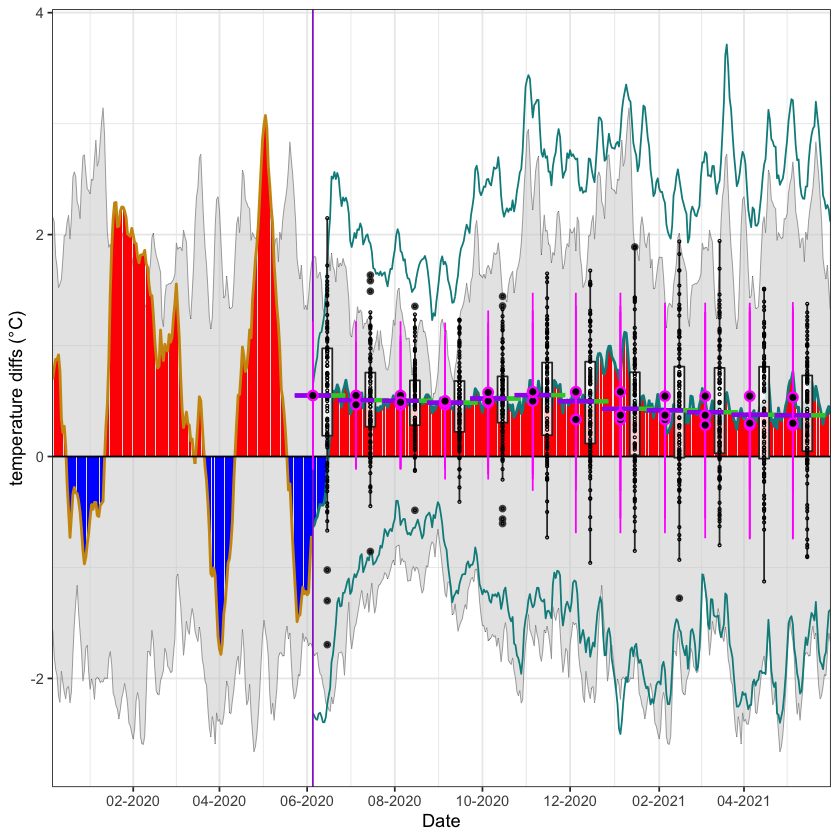

In [89]:
####### This is a lot of code!
source('figureCode/presentationFigs/FigureDataPrep.R')
source('figureCode/presentationFigs/Temperature.R')


## Precipitation 

### Leads - Generated lead anomaly data vs. NWS lead forecasts

[1] "Density plots of predicted LEAD Anomalies"


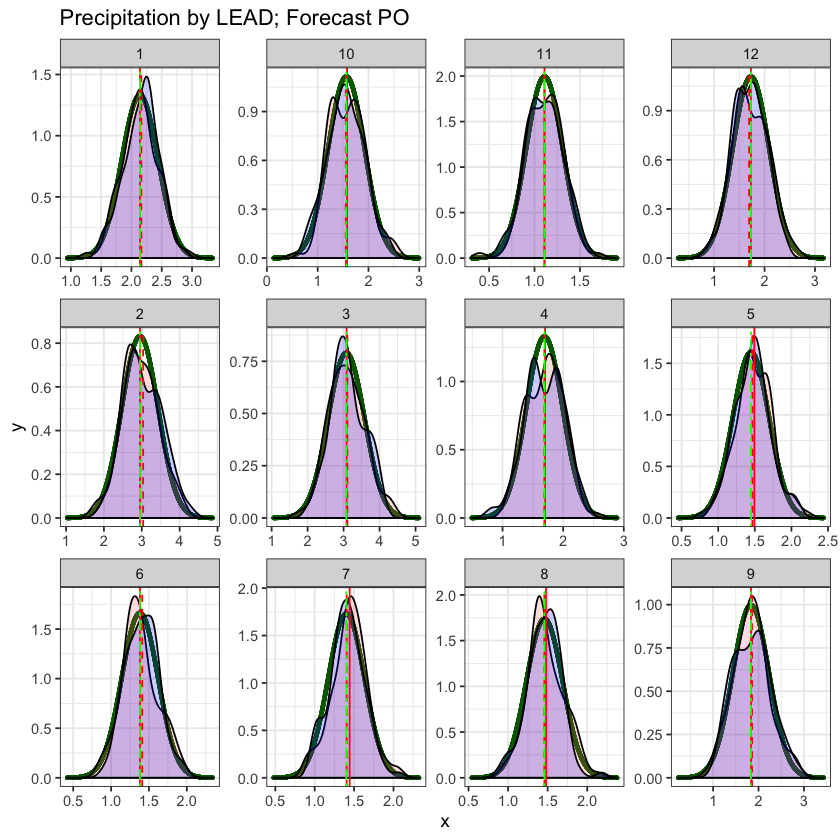

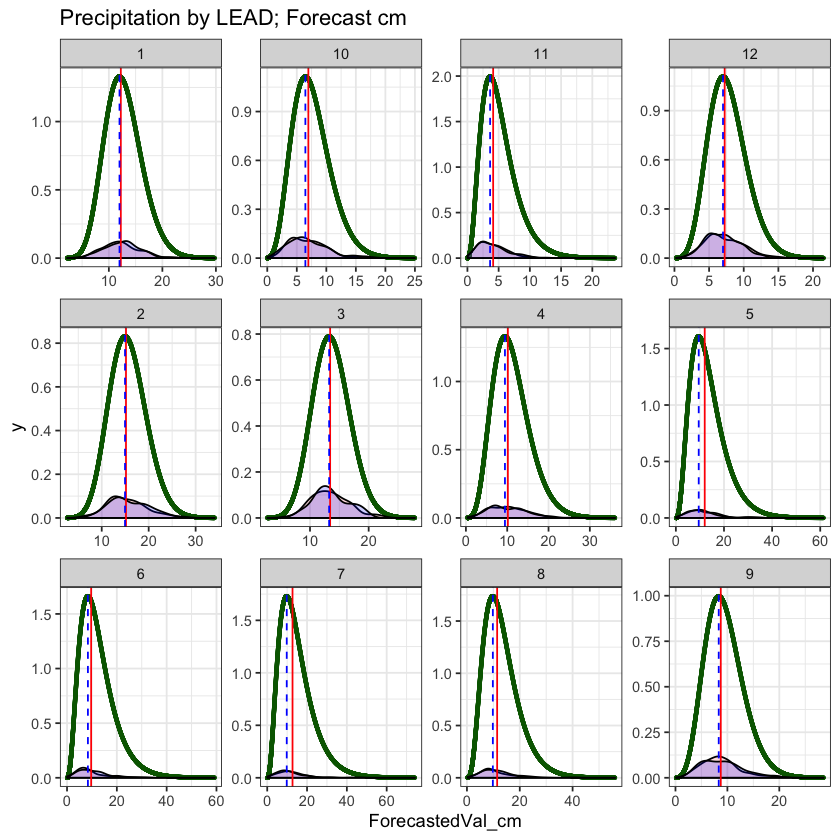

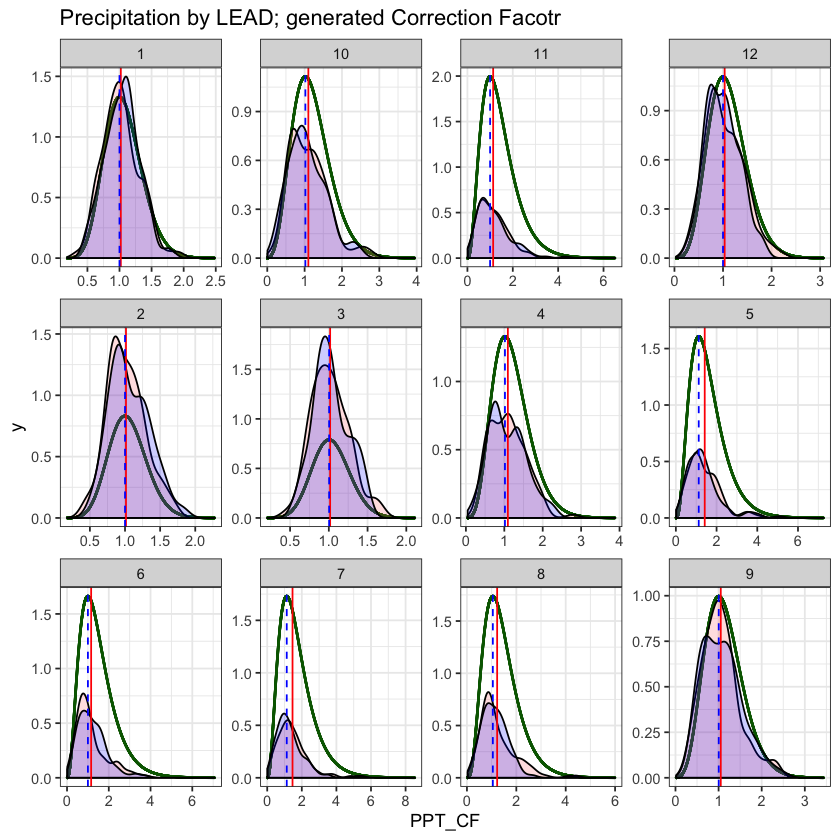

In [22]:
print('Density plots of predicted LEAD Anomalies')

pptNWSDensity <- PPTAnoms[,.(vals = rnorm(100, mean = ForecastedMEAN_PPT_PO, sd = ForecastedSD)), .(LEAD)]
pptNWSDensityMean <- pptNWSDensity[,.(Anom_mean = mean(vals)), .(LEAD)]

pptNWSDensity <- merge(pptNWSDensity, PPTAnoms[,c('LEAD', 'PO', 'ForecastedSD', 'ForecastedMEAN_PPT_PO', 'ForecastedMEAN_PPT_cm', 'ClimatatologicalMEAN_PPT_cm')])
pptNWSDensity$ForecastedVal_in <- (pptNWSDensity$vals) ^ (1/pptNWSDensity$PO)
pptNWSDensity$ForecastedVal_cm <- pptNWSDensity$ForecastedVal_in * 2.54
pptNWSDensity$PPT_CF <- pptNWSDensity$ForecastedVal_cm / pptNWSDensity$ClimatatologicalMEAN_PPT_cm
#summary(pptNWSDensity)

# theoreritcal distribution
pptTheoreticalDensity <- data.frame()

for(i in 1:12){
  z <- subset(PPTAnoms, LEAD == i)
  x <-  seq(z$ForecastedMEAN_PPT_PO - (z$ForecastedSD * 4), 
           z$ForecastedMEAN_PPT_PO + (z$ForecastedSD * 4), length = 3000) 
  y <-  dnorm(x, mean = z$ForecastedMEAN_PPT_PO, sd = z$ForecastedSD)
  
  pptTheoreticalDensity <- rbind(pptTheoreticalDensity, data.frame(x = x, y = y, LEAD = i))
}
pptTheoreticalDensityMean <- setDT(pptTheoreticalDensity)[,.(Anom_mean = mean(x)),.(LEAD)]

pptTheoreticalDensity <- merge(pptTheoreticalDensity, PPTAnoms[,c('LEAD', 'PO', 'ClimatatologicalMEAN_PPT_cm')])
pptTheoreticalDensity$ForecastedVal_in <- (pptTheoreticalDensity$x) ^ (1/pptTheoreticalDensity$PO)
pptTheoreticalDensity$ForecastedVal_cm <- pptTheoreticalDensity$ForecastedVal_in * 2.54
pptTheoreticalDensity$PPT_CF <- pptTheoreticalDensity$ForecastedVal_cm / pptTheoreticalDensity$ClimatatologicalMEAN_PPT_cm

# experiment with number in untransformed units
pptGenAnoms <- data.table(generatedAnomData[, , "PT_GenForecasted_PO"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms$LEAD <- factor(pptGenAnoms$LEAD, levels = c(1:12))
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(Forecast_mean = mean(value)),.(LEAD)]

ggplot() +
  
  geom_point(data = pptTheoreticalDensity, aes(x = x, y = y), color = 'darkgreen',  size = .6) +
  geom_density(data = pptGenAnoms, aes(value), alpha=.2, fill="#FF6666") +
  geom_density(data = pptNWSDensity, aes(vals), alpha=.2, fill="blue") + 
  
  facet_wrap(~LEAD, scales = 'free') +
  labs(title = 'Precipitation by LEAD; Forecast PO') +
  
  geom_vline(data = pptGenAnomsMean, aes(xintercept = Forecast_mean), color = 'red')+
  geom_vline(data = pptNWSDensityMean, aes(xintercept = Anom_mean), color = 'red', lty = 'dashed') +
  geom_vline(data = pptTheoreticalDensityMean, aes(xintercept = Anom_mean), color = 'green', lty = 'twodash') +
  theme_bw()

# ----------------- in centimeters ------------------------------------
pptGenAnoms <- data.table(generatedAnomData[, , "PPT_GenForecasted_cm"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(Forecast_mean = mean(value)),.(LEAD)]

ggplot() +
  geom_point(data = pptTheoreticalDensity, aes(x = ForecastedVal_cm, y = y), color = 'darkgreen',  size = .6) +
  geom_density(data = pptGenAnoms, aes(value), alpha=.2, fill="#FF6666") +
  geom_density(data = pptNWSDensity, aes(ForecastedVal_cm), alpha=.2, fill="blue") +
  
  facet_wrap(~LEAD, scales = 'free') +
  labs(title = 'Precipitation by LEAD; Forecast cm') +
  
  geom_vline(data = pptGenAnomsMean, aes(xintercept = Forecast_mean), color = 'red')+
  geom_vline(data = PPTAnoms[1:12, ], aes(xintercept = ForecastedMEAN_PPT_cm), color = 'blue',  lty = 'dashed')+
  theme_bw()


# --------------------- Correction factor ----------------------------
pptGenAnoms <- data.table(generatedAnomData [, , "PPT_CF"])
pptGenAnoms$LEAD <- row.names(pptGenAnoms)
pptGenAnoms <- melt(pptGenAnoms, id.vars = 'LEAD')
pptGenAnomsMean <- pptGenAnoms[,.(PPT_CF = mean(value)),.(LEAD)]

ggplot() +
  geom_point(data = pptTheoreticalDensity, aes(x = PPT_CF, y = y), color = 'darkgreen', size = .1) +
  
  geom_density(data = pptGenAnoms, aes(value), alpha=.2, fill="#FF6666") +
  geom_density(data = pptNWSDensity, aes(PPT_CF), alpha=.2, fill="blue") +
  
  facet_wrap(~LEAD, scales = 'free') +
  labs(title = 'Precipitation by LEAD; generated Correction Factorr') +
  
  geom_vline(data = pptGenAnomsMean, aes(xintercept = PPT_CF), color = 'red') +
  geom_vline(data = PPTAnoms[1:12, ], aes(xintercept = Anom_CF), color = 'blue',  lty = 'dashed')+
  theme_bw()



[1] "Density and box plots of monthly anomalies used in SOILWAT2 vs NWS"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


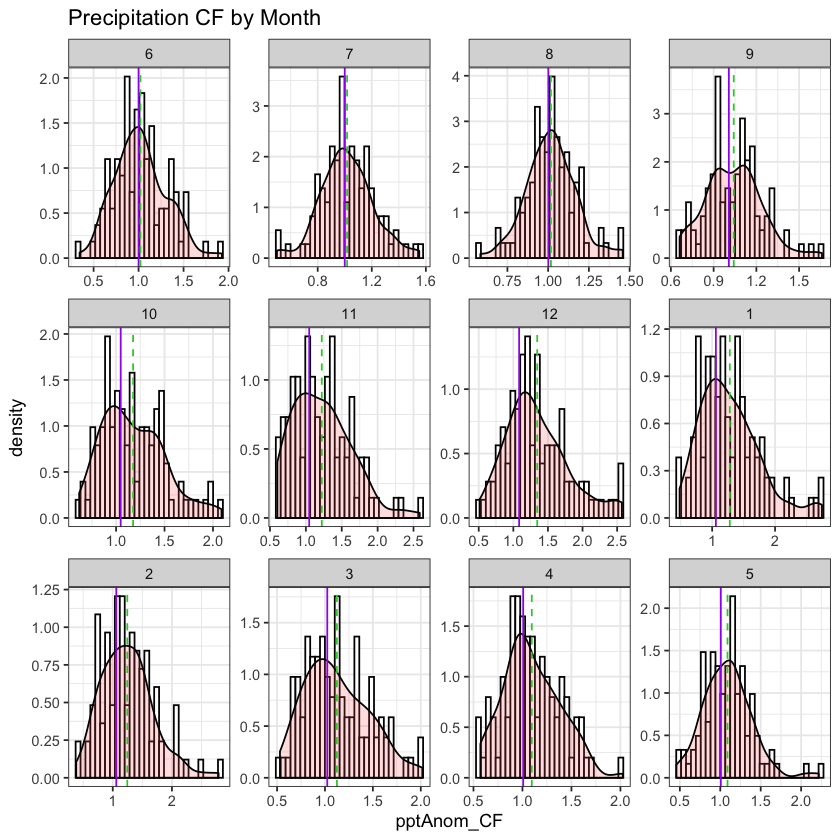

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



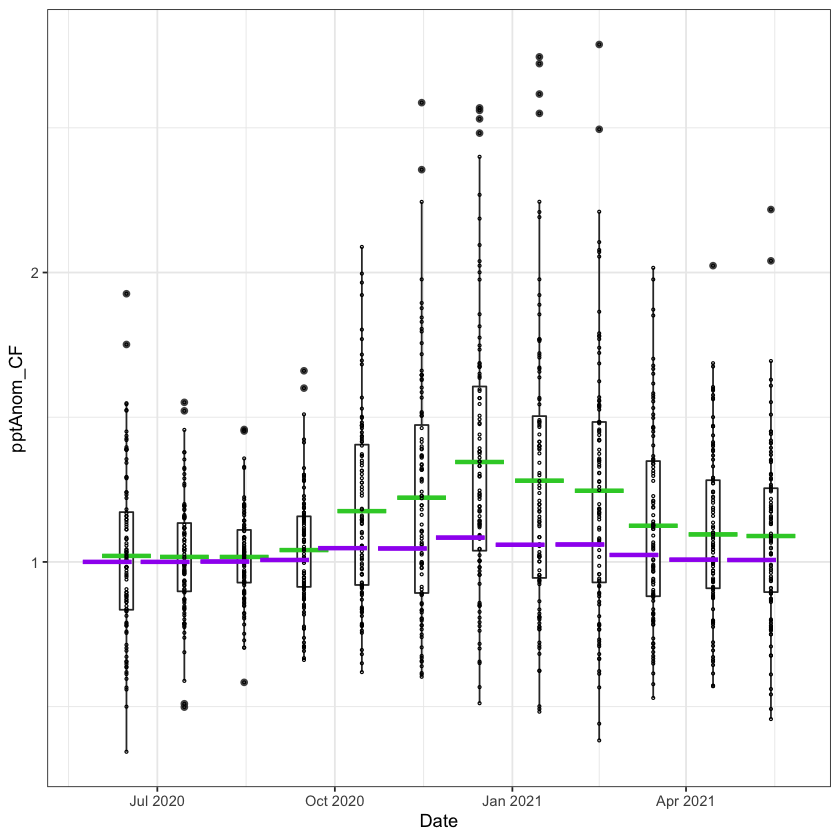

Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


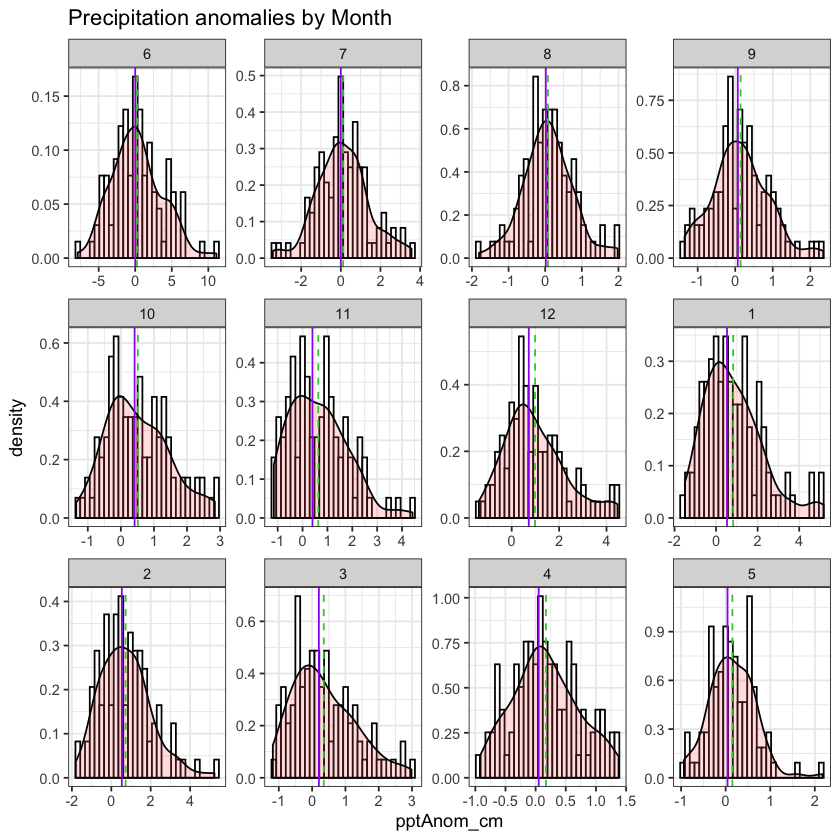

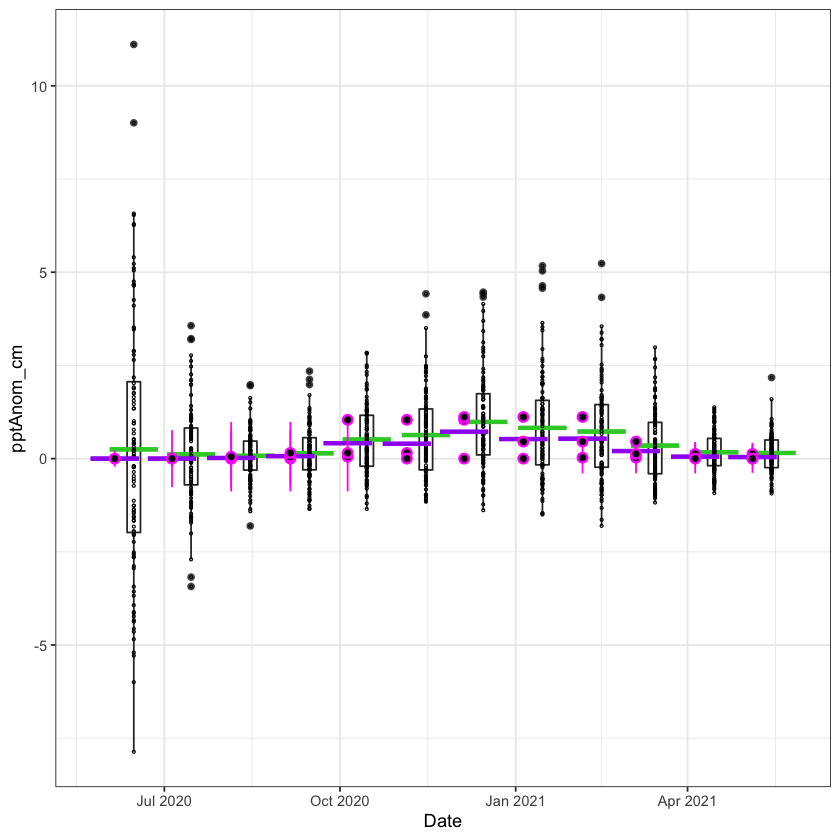

In [26]:
# Plots comparing the distribution of generated anomaly data at the Monthly level
# to NWS values for the same monthly periods

print('Density and box plots of monthly anomalies used in SOILWAT2 vs NWS')

# Correction Factor
NWSMeans <- setDT(NWSAnomsAll2)[,.(meanForecastDiff = mean(Anom_CF)), .(m)]
names(NWSMeans)[1] <- 'Month'

generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(pptAnom_CF)), .(Month)]
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

# hists
ggplot(MonthlyAnoms2, aes(pptAnom_CF)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="#FF6666") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Precipitation CF by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw()

# boxplots
ggplot() +
  geom_boxplot(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, pptAnom_CF, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  theme_bw()




generatedMean <- setDT(MonthlyAnoms2)[,.(meanGenAnom = mean(pptAnom_cm)), .(Month)]

# ----- 100 sets of monthly anomalies vs. affiliated NWS data

NWSMeans <- setDT(NWSAnomsAll2)[,.(meanForecastDiff = mean(Anom_cm)), .(m)]
names(NWSMeans)[1] <- 'Month'
NWSMeans$Month <- factor(NWSMeans$Month, levels = c(6:12, 1:5))
NWSMeans$Year <- c(rep(2021,5), rep(2020, 7))
NWSMeans$Date <- as.Date(paste0(NWSMeans$Year, '-', NWSMeans$Month, '-05'))

# hists
ggplot(MonthlyAnoms2, aes(pptAnom_cm)) +
  geom_histogram(aes(y=..density..), colour="black", fill="white")+
  geom_density(alpha=.2, fill="#FF6666") +
  facet_wrap(~Month, scales = 'free') +
  labs(title = 'Precipitation anomalies by Month') +
  geom_vline(data = NWSMeans, aes(xintercept = meanForecastDiff), color = 'purple') +
  geom_vline(data = generatedMean, aes(xintercept = meanGenAnom), color = 'limegreen', linetype = 'dashed')+
  theme_bw()

# boxplots
ggplot() +
  geom_boxplot(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month), fatten = NULL, width = 7, alpha = 0.8) +
  stat_summary(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'limegreen') +
  geom_point(data = MonthlyAnoms2, aes(Date, pptAnom_cm, group = Month), shape = 21, size =.5, fill = NA) +
  # NWS dots and lines
  stat_summary(data = NWSMeans, aes(Date, meanForecastDiff, ymax = ..y.., ymin = ..y..),
               fun.y = mean, geom = "errorbar", size = 1.2, color = 'purple') +
  geom_pointrange(data = NWSAnomsAll2, aes(Date, Anom_cm,
                                           ymin = Anom_cm - ForecastedSD_PPT_cm,
                                           ymax = Anom_cm + ForecastedSD_PPT_cm), shape = 21, fill = 'black', color = 'magenta') +
  theme_bw()



